# Classifying Heart Disease Via Logistic Regression

## Introduction
---
With this project we attempt to build a logistic regression model that is successful at predicting whether a patient has developed a heart disease or not, based on the patient's medical history. The analysis relies on the use k-fold cross validation and bootstrap techniques to produce average prediction scores that should provides us a reliable sense of the predictive power of the models analyzed.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import cross_validate
from sklearn.utils import resample 

## Data Set Description 
---
Attribute Information ([source](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)):


| Variable      |Description       | Additional Information              |
| ------------- | ---------------- | ----------------------------------- |
| `age`           | Age in years.    | -                                       |
| `sex`           | - `0` = female.<br>- `1` = male. |  -                        |
| `cp`            | Chest pain type:<br>- `Value 1`: typical angina<br>- `Value 2`: atypical angina<br>- `Value 3`: non-anginal pain<br>- `Value 4`: asymptomatic | -     |
| `trestbps`      | Resting blood pressure mm Hg. | In mm Hg [milliliters of mercury] on admission to the hospital. |
| `chol`          | Serum cholesterol in mg/dl.   | Levels in milligrams per deciliter.                             |
| `fbs`           | - `0` = false<br>- `1` = true | Fasting blood sugar > 120 mg/dl This test measures sugar (glucose) in the blood:<br>- 99 mg/dL or lower: This is a normal fasting blood sugar level.<br>- 100–125 mg/dL: Fasting blood sugar in this range typically indicates prediabetes.<br>- 126 mg/dL or above: This indicates high blood sugar, the main sign of diabetes. |
| `restecg`       | Resting electrocardiographic results:<br>- `Value 0`: normal.<br>- `Value 1`: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV).<br>- `Value 2`: showing probable or definite left ventricular hypertrophy by Estes' criteria. | -             |
| `thalach`       | Maximum heart rate achieved.                               |                  -           |
| `exang`         | Exercise induced angina:<br>- `0` = no.<br>- `1` = yes.           |     -                                                                 |
| `oldpeak`       | ST depression.         | [ST depression](https://en.wikipedia.org/wiki/ST_depression) induced by exercise relative to rest (mm).   |
| `slope`         | The slope of the peak exercise ST segment:<br>- `Value 1`: upsloping.<br>- `Value 2`: flat.<br>- `Value 3`: downsloping.      | -     |
| `ca`            | Number of major vessels (0-3) colored by fluoroscopy. |  During this procedure, if a larger number of vessels are observed to be colored, it could suggest a higher likelihood of multiple blockages or a more extensive disease affecting the coronary arteries.                                                                         |
| `thal`          | Presence of thalassemia (a blood disorder):<br>- `3` = normal.<br>- `6` = fixed defect (no blood flow in some part of the heart).<br>- `7` = reversible defect (a blood flow is observed but it is not normal).                                                                           | -     |
| `present` | Diagnosis of heart disease (angiographic disease status):<br>- `Value 0`: < 50% diameter narrowing.<br>- `Value 1`: > 50% diameter narrowing. | -      |


## Exploratory Data Analysis And Feature Selection
---

In [2]:
heart = pd.read_csv('heart_disease.csv', index_col=0)

heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 1 to 303
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  present   303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 35.5+ KB


In [3]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### Preliminary steps:

1. Convert the following categorical variables into dummies: 
    - `cp` (chest pain),
    - `restecg` (resting electrocardiographic results),
    - `thal` (presence of thalassemia)
    - `slope` (ST segment slope).
    
    
2. Analyze box plots of predictors controlling for the target variable classes.

In [4]:
cp_dict = {
    1: 'typical_angina',
    2: 'atypical_angina',
    3: 'non-anginal_pain',
    4: 'asymptomatic',
    }

restecg_dict = {
    0: 'normal',
    1: 't_wave_abnormality',
    2: 'ventricular_hypertrophy',
    }

thal_dict = {
    '?': 'inconclusive',
    '3.0': 'normal',
    '6.0': 'fixed_defect',
    '7.0': 'reversible_defect',
    }

slope_dict = {
    1: 'upsloping',
    2: 'flat',
    3: 'downsloping',
    }

heart.cp = heart.cp.map(cp_dict)

heart.restecg = heart.restecg.map(restecg_dict)

heart.thal = heart.thal.map(thal_dict)

heart.slope= heart.slope.map(slope_dict)

Before we turn the categorical variables into dummies we look at their frequency distribution in order to exclude subcategories which have a very small representation (inferior to 5%).

In [5]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',]
categorical = [col for col in heart.columns if col not in numerical]

for col in categorical:
    print(heart[col].value_counts(normalize=True))
    print('---------------------------------------------')

1    0.679868
0    0.320132
Name: sex, dtype: float64
---------------------------------------------
asymptomatic        0.475248
non-anginal_pain    0.283828
atypical_angina     0.165017
typical_angina      0.075908
Name: cp, dtype: float64
---------------------------------------------
0    0.851485
1    0.148515
Name: fbs, dtype: float64
---------------------------------------------
normal                     0.498350
ventricular_hypertrophy    0.488449
t_wave_abnormality         0.013201
Name: restecg, dtype: float64
---------------------------------------------
0    0.673267
1    0.326733
Name: exang, dtype: float64
---------------------------------------------
upsloping      0.468647
flat           0.462046
downsloping    0.069307
Name: slope, dtype: float64
---------------------------------------------
0.0    0.580858
1.0    0.214521
2.0    0.125413
3.0    0.066007
?      0.013201
Name: ca, dtype: float64
---------------------------------------------
normal               0.547855


As we can observe in the values above, `t_wave_abnormality` (`restecg`)  and `inconclusive` (`thal`) are categories that possess a very small representation - under 5%, therefore we exclude the rows associated with these values. Next, we convert all the categorical variables into sets of dummies.

Relative to `ca` (heart fluoroscopy) we can observe that there is a irrelevant category called `?` that we eliminate by removing the associated rows. This variable can be fitted as an ordinal variable, since the more colored vessels, the more likely is the presence of heart disease, or as a set of dummies; we'll pick the former version, to prevent the excess of dummy variables in the model. 

In [6]:
heart = heart.query('restecg != "t_wave_abnormality" & thal != "inconclusive" & ca != "?"')

heart = (
    pd.get_dummies(
        data=heart,
        columns=['cp', 'restecg', 'thal', 'slope']
    )
    .drop(
        columns=['restecg_normal', 'cp_asymptomatic', 'thal_normal', 'slope_upsloping']
    )
)

Converting "ca" into an ordinal variable (integers):

In [7]:
heart.ca.unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [8]:
heart.ca = heart.ca.apply(lambda x: int(float(x)))

heart.ca.unique()

array([0, 3, 2, 1])

Checking `heart` after the modifications made so far.

In [9]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 1 to 302
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              293 non-null    int64  
 1   sex                              293 non-null    int64  
 2   trestbps                         293 non-null    int64  
 3   chol                             293 non-null    int64  
 4   fbs                              293 non-null    int64  
 5   thalach                          293 non-null    int64  
 6   exang                            293 non-null    int64  
 7   oldpeak                          293 non-null    float64
 8   ca                               293 non-null    int64  
 9   present                          293 non-null    int64  
 10  cp_atypical_angina               293 non-null    uint8  
 11  cp_non-anginal_pain              293 non-null    uint8  
 12  cp_typical_angina     

### Frequency distribution observation.

Next, we observe the distribution of the non-binary predictors.

In [10]:
all_feats = [col for col in heart.columns if col != 'present']

non_binary = [col for col in heart.columns if len(heart[col].unique()) > 2]
      
non_binary

['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

In [11]:
heart[non_binary].describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,54.453925,131.573379,247.153584,149.924915,1.032765,0.672355
std,9.021783,17.620395,51.837275,22.897205,1.147937,0.933667
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,48.000000,120.000000,212.000000,136.000000,0.000000,0.000000
50%,56.000000,130.000000,243.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000


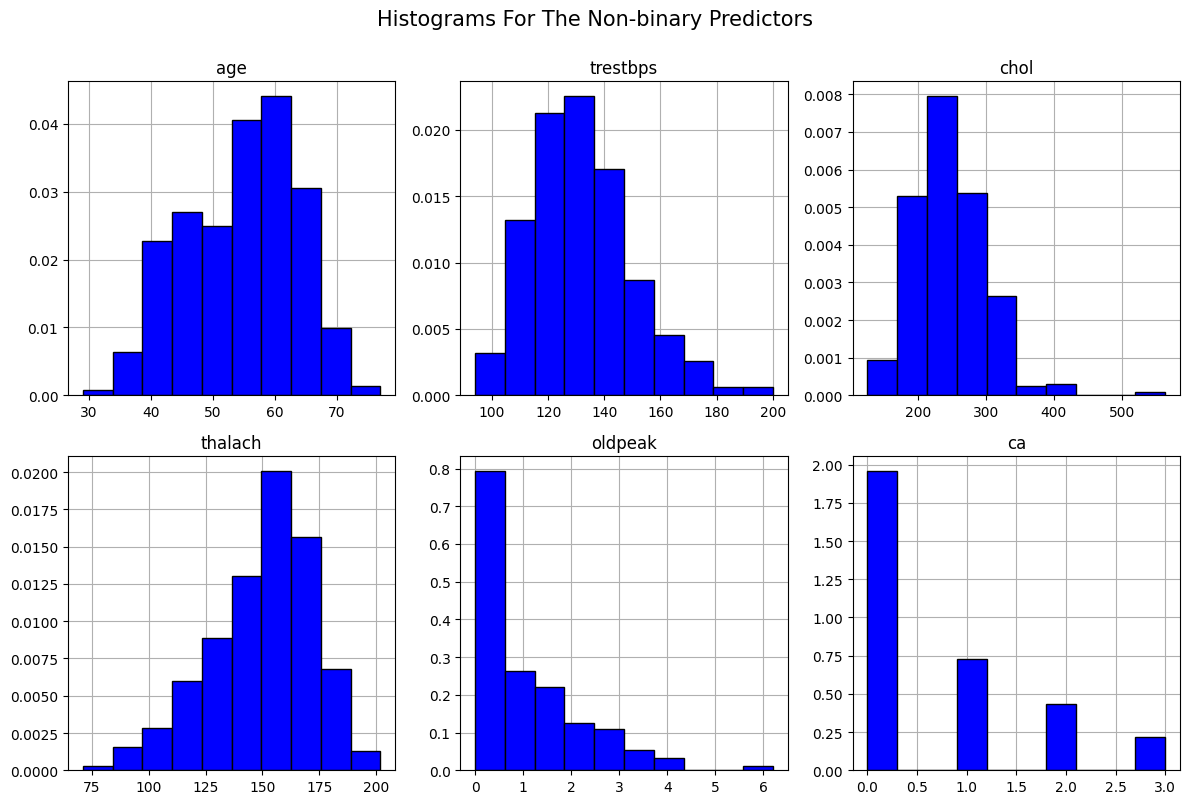

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

plt.suptitle(
    "Histograms For The Non-binary Predictors",
    size=15,
    y=1.0
    )

for i in range(0, 5+1):    
    if i < 3:
        ax_ = ax[0, i]
    if 3 <= i <= 6:
        ax_ = ax[1, i-3]

    col = non_binary[i]
    ax_.hist(heart[col], density=True, edgecolor = "black", color='blue')
    ax_.set_title(non_binary[i])
    ax_.grid()
    ax_.set_axisbelow(True)
                
plt.tight_layout()
plt.show()

As we can see in the panel of histograms above, there at least three variables with very distant values from the mean, namely for `chol`, `oldpeak`, and possibly `trestbps`. Given that `oldpeak` shows an exponential negative continuous distribution, it could be a candidate to be replaced by its logarithm version, in order to linearize the relationship between the explanatory variable and the log-odds of the outcome, as well as compress the scale of the distribution range, thus mitigating the impact of outliers. Notwithstanding, the most frequent value in this array is zero, which prevents log transformation; also, the scale is relatively small and compact (values ranging from 0 to 6.2), therefore, we keep the original `oldpeak` variable.  

### Removing outliers.

In order to identify outliers, we'll be resorting to box plot analysis. First, we observe the distribution of the non-binary variables, remove outliers if necessary, and observe another panel of box plots for the same variables, but this time discriminating by the associated target value: `0` (no presence of heart disease), `1` (presence of heart disease). 

As a reminder, the measurement units of each variable is the following:
- `age`: years.
- `trestbps` (resting blood pressure): milligrams of mercury (mm of Hg).
- `chol` (serum cholesterol): milligrams per deciliter (mg/dL).
- `thalach` (maximum heart rate achieved): beats per minute.
- `oldpeak` (ST depression induced by exercise relative to rest): millimeters (mm). 
- `ca` (heart fluoroscopy): number of vessels colored during the procedure.

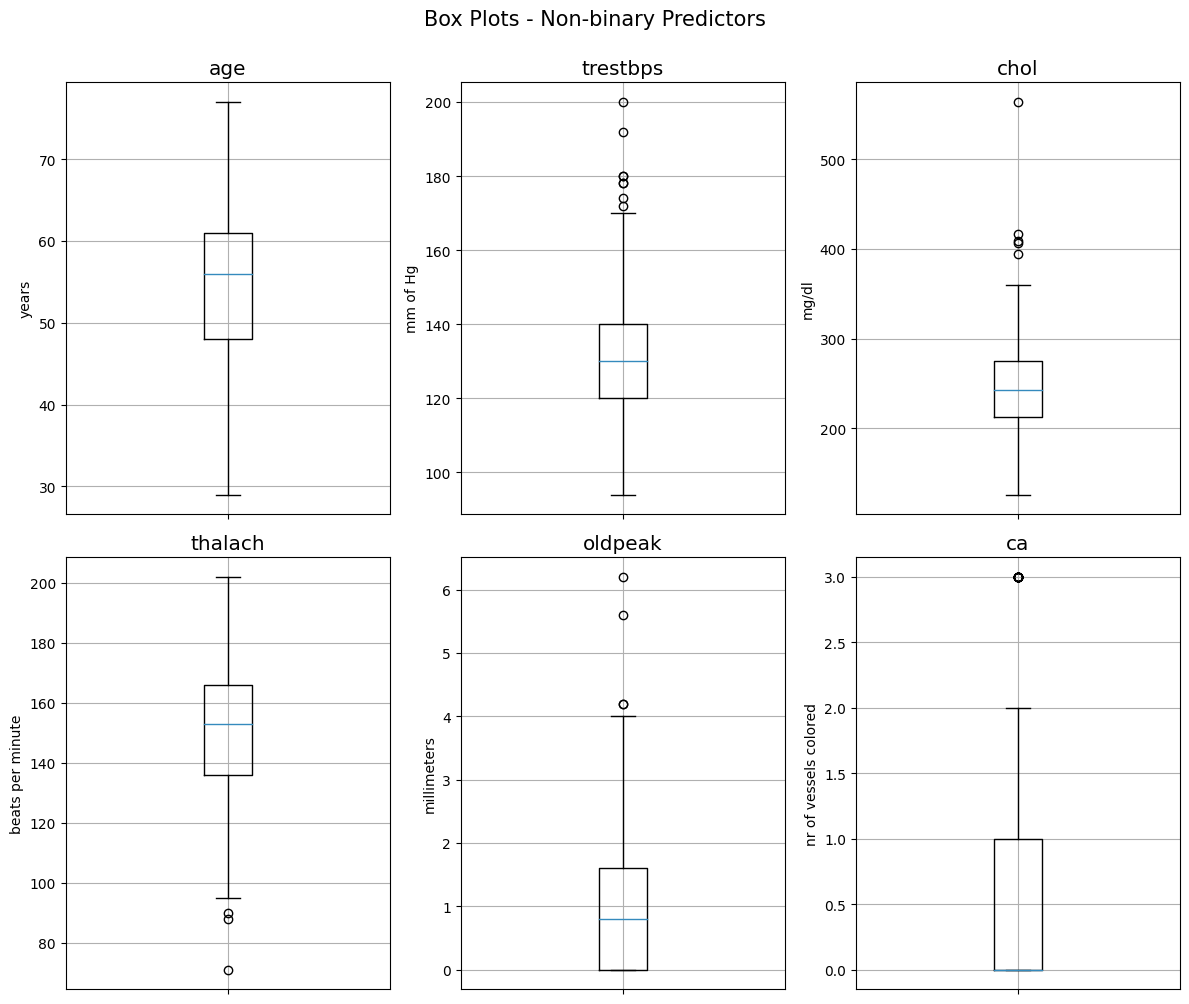

In [13]:
non_binary_labels = ['years', 'mm of Hg', 'mg/dl', 'beats per minute', 'millimeters', 'nr of vessels colored']


fig, ax = plt.subplots(2, 3, figsize=(12, 10))

plt.style.use('ggplot')

plt.suptitle(
    'Box Plots - Non-binary Predictors',
    size=15,
    y=1.0
    )

for i in range(0, 5+1):    
    if i < 3:
        ax_ = ax[0, i]
    if 3 <= i <= 6:
        ax_ = ax[1, i-3]
    
    col = non_binary[i]
    ax_.boxplot(heart[col])
    ax_.set_title(non_binary[i])
    ax_.set_xticklabels('')
    ax_.set_ylabel(non_binary_labels[i])
    ax_.grid()
    ax_.set_axisbelow(True)
        
plt.tight_layout()
plt.show()

After analyzing the box plot panel above, we'll be conservative and only remove values in `chol` that are over 500 mg/dl, since we can consider them as extreme outliers. There are values in the other variables that also surpass either the upper interquartile range threshold - `trestbps`, `oldpeak`, `ca` and the analogous lower threshold - `thalach`, but at lower magnitudes, therefore, we keep them untrimmed.

In [14]:
heart = heart.query('chol < 500')

### Box plot analysis of non-binary predictors: discriminating by target value.

For each predictor, we observe its frequency distribution stratifying each sample based on the target: the patients without heart disease and those with heart disease.

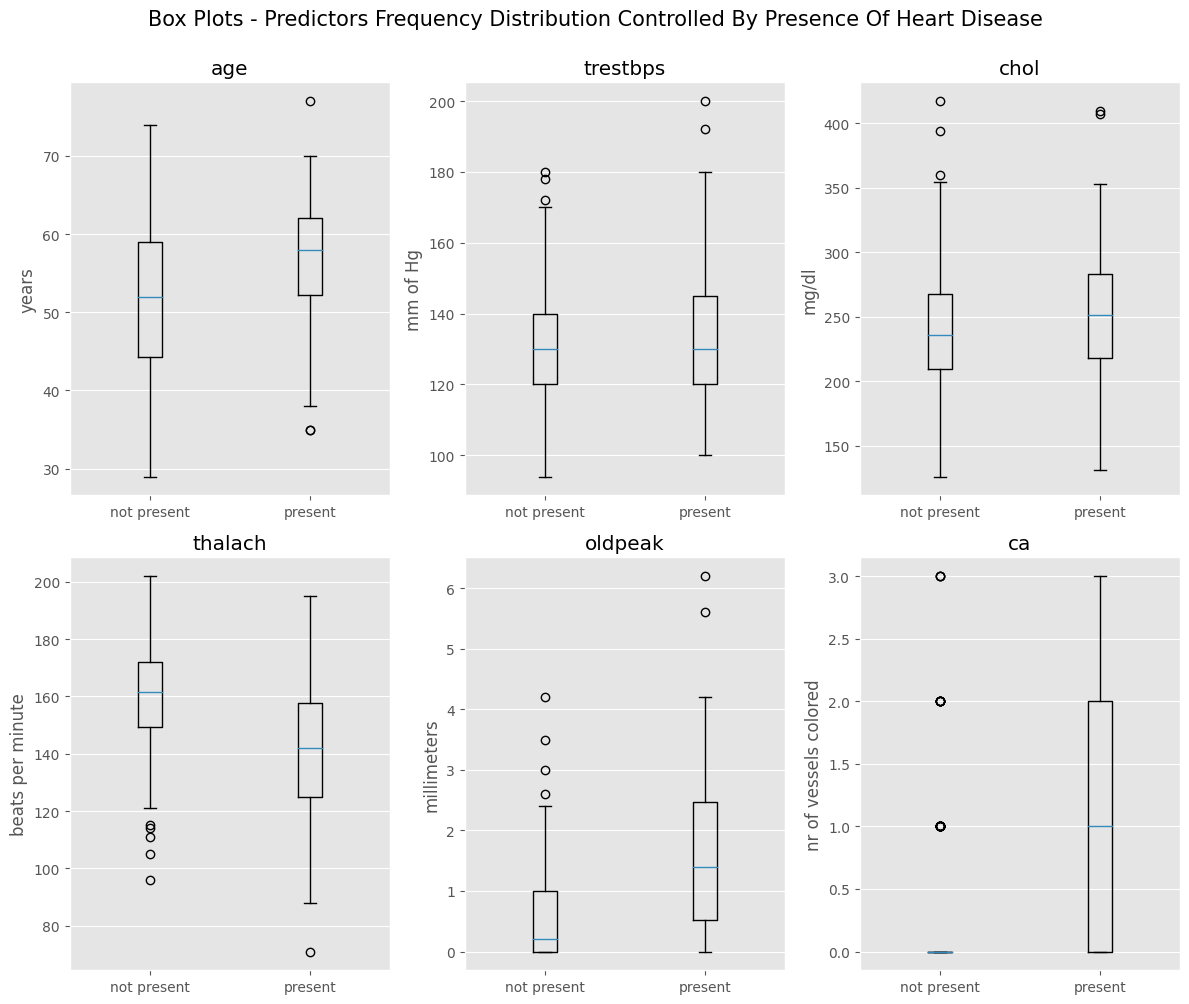

In [15]:
disease = heart.query('present  == 1')
no_disease = heart.query('present  == 0')

fig, ax = plt.subplots(2, 3, figsize=(12, 10))

plt.style.use('ggplot')

plt.suptitle(
    'Box Plots - Predictors Frequency Distribution Controlled By Presence Of Heart Disease',
    size=15,
    y=1.0
    )

for i in range(0, 5+1):    
    if i < 3:
        ax_ = ax[0, i]
    if 3 <= i <= 6:
        ax_ = ax[1, i-3]
    
    not_present = no_disease[non_binary[i]].values
    present = disease[non_binary[i]].values
    ax_.boxplot([not_present, present])
    ax_.set_xticklabels(['not present', 'present'])
    ax_.set_title(non_binary[i])
    ax_.set_ylabel(non_binary_labels[i])
    ax_.grid(axis='x')
    ax_.set_axisbelow(True)
        
plt.tight_layout()
plt.show()

- `age`: visually, there seems to be a difference in distribution between samples where heart disease is only presence in older individuals (mid 30's and up); otherwise, is difficult to distinguish a clear pattern that could indicate that becoming older is a factor of heart disease: there older people without hear disease that with heart disease  (people over 70 years old).


- `trestbps` (resting blood pressure): in this case, the difference between frequency distributions is small, but the minimum value and maximum values seem higher for individuals with heart disease.  


- `chol` (serum cholesterol): this variable also shows similar frequency distributions for 'present' and 'note present', therefore we exclude this variable.


- `thalach` (maximum heart rate achieved): in this case we can see a difference in the distributions where the individuals with heart disease are prone to exhibit lower heart rate when compared with the healthy individuals, both in terms of maximum and minimum values observed.


- `oldpeak` (ST depression induced by exercise relative to rest): this variable also shows a visible difference in frequency distributions: the ST depression, is in general, higher for patients with heart disease when compared with patients without heart disease. 


- `ca` (heart fluoroscopy): when observing the values for healthy individuals it looks that values of 0 are outliers, where the distribution of the values for individuals with heart disease is much more even. This may indicate that this variable is relevant to predict heart disease.   

Dropping `chol`.

In [16]:
heart = heart.drop(columns=['chol'])

### Variance Inflation Factor (VIF) analysis.

Next we compute a battery of auxiliary regressions to check for multicollinearity.

An exploratory VIF analysis showed that the variable `trestbps` was consistently producing very high VIF values (over 10) which indicate a high collinearity of this variable in regards to the remaining predictors (see the column `all_features_with_trestbps`)' in the DataFrame below); Because it was already dubious from the last box plot comparison that this variable was relevant we decide to remove it from the following stages of the analysis.  

In [17]:
features = [col for col in heart.columns if col != 'present']

feats_dict = {
    'all_features_with_trestbps': features,
    'all_features': [col for col in features if col not in ['trestbps']],
    'no_age': [col for col in features if col not in ['age', 'trestbps']],
    'no_thalach': [col for col in features if col not in ['thalach', 'trestbps']],
    'no_age_thalach': [col for col in features if col not in ['thalach', 'age', 'trestbps']]
    }


# VIF DataFrame.
vif_data = pd.DataFrame(index=heart[features].columns)
  
for feat_set in feats_dict:
    feats = feats_dict[feat_set]
    vif_list = [vif(heart[feats].values, i) for i in range(len(heart[feats].columns))]
    vif_series = pd.Series(vif_list, index=feats, name=feat_set)
    
    vif_data = pd.concat([vif_data, vif_series], axis=1)

vif_data

,all_features_with_trestbps,all_features,no_age,no_thalach,no_age_thalach
age,38.019911,24.283750,NaN,8.172304,NaN
sex,3.857222,3.846628,3.845945,3.648887,3.313278
trestbps,61.667066,NaN,NaN,NaN,NaN
fbs,1.307833,1.296384,1.290965,1.293848,1.290691
thalach,34.309126,21.341671,7.182195,NaN,NaN
exang,2.032207,2.012779,1.962213,2.011575,1.896724
oldpeak,3.259805,3.215423,3.197182,3.214181,3.180569
ca,2.106101,2.098658,1.876350,2.019587,1.844916
cp_atypical_angina,1.805409,1.803910,1.803401,1.628503,1.235444
cp_non-anginal_pain,2.081334,2.080833,2.073117,1.918981,1.405896


The model with all the features shows that (2nd column; `trestbps` already excluded), when we calculate the VIF for every predictor, there is some evidence of multicollinearity regarding some variables. We consider values above 4 to be a cause of concern and values over 10 to indicate high multicollinearity. The 'all_features' column show that there are at least two cases of high collinearity among predictors: `age` and `thalach`. When recalculating the VIF values without `age` (3rd column) we have a single value over 4 which is for `thalach` - 7.18; when we exclude `thalach` instead (4th column), the only VIF value over 4 is for `age` - 8.17; excluding both `age` and `thalach` (5th column) only yields VIF values below 4, which dissipates the multicollinearity problem. Instead of working with only one group of predictors we'll be estimating logistic regressions for these groups of variables (the combinations of explanatory variables included in 2nd to 5th column) and compare their predictive power.   

Removing `trestbps` from `heart` and from `feats_dict`:

In [18]:
heart = heart.drop(columns=['trestbps'])

feats_dict = {
    key: feats_dict[key] for key in feats_dict if key != 'all_features_with_trestbps'
}

## Logistic Regression: Model Fitting And Prediction 
---
For this analysis we randomly split the train and the test set into 60 and 40% sub-sample sizes, respectively, with a pseudo-random state to be set by `stratify_evenly()`: this function splits the `X` and `y` DataFrames into train and test sets, by looking for the first random state that allows to stratify the data so that both the train and test sets have around half of the observations/individuals with heard disease. We set a 5% tolerance variance that allows these portions to take up a percentage between 45% and 55%.

In [19]:
features = [col for col in heart.columns if col != 'present']

X = heart[features]

y = heart.present

def stratify_evenly(X, y):
    """Perform different splitting processes (up to 10000) until both train and test sets are 
    evenly devided between the values of the binary target, with a positive and negative 5% margin.   
    """
    for i in range(10000):
        X_train, X_test, y_train, y_test = split(
            X,
            y,
            test_size=0.4,
            random_state=i,
            shuffle=True,
            )
        
        train_no_desease = y_train.value_counts(normalize=True).round(2)[0]
        test_no_desease = y_test.value_counts(normalize=True).round(2)[0]
        
        if (0.45 <= train_no_desease <= 0.55) & (0.45 <= test_no_desease <= 0.55):
            print(f'Random state: {i} (for replication purposes).')
            return [X_train, X_test, y_train, y_test]
        
    return print('No convergence found.') 

In [20]:
list_results = stratify_evenly(X, y)

X_train, X_test, y_train, y_test = list_results 

Random state: 1 (for replication purposes).



Checking the distribution of `present` in the train and test sets.

In [21]:
pd.DataFrame(
    {
        'train': y_train.value_counts(normalize=True).round(2),
        'test': y_test.value_counts(normalize=True).round(2),
    }
)

,train,test
0,0.54,0.55
1,0.46,0.45


As we can see both `y` train and test sets are evenly distributed, showing values between 45 and 55%. for both `0` (absence of heart disease) and `1` (presence of heart disease).


### Part I - Using the train set to fit and make control predictions.


Besides fitting and producing predictions resorting solely to the train set, we calculate the prediction metrics (scores) that allow us to assess the predictive power of the model: 

- accuracy (overall capability to predict the outcome).
- sensitivity (capability to successfully predict cases of heart disease).
- specificity (capability to successfully predict cases of absence of heart disease).

In [22]:
def log_model(features, X, y):
    logistic = LogisticRegression(max_iter=10000)
    model = logistic.fit(X[features].values, y.values)
    return model

def return_scores(features, model, X, y):
    prediction = model.predict(X[features].values)
    
    # Accuracy.
    accuracy = sum(prediction == y) / y.shape[0]
    accuracy = round(accuracy*100, 2)
    
    # Sensitivity.
    true_positives =  sum((prediction == y) & (prediction == 1))
    false_negatives = sum((prediction != y) & (prediction == 0))
    
    sensitivity = true_positives / (true_positives + false_negatives)
    sensitivity = round(sensitivity*100, 2)
    
    # Specificity.
    true_negatives = sum((prediction == y) & (prediction == 0))
    false_positives = sum((prediction != y) & (prediction == 1))
    
    specificity = true_negatives / (true_negatives + false_positives)
    specificity = round(specificity*100, 2)
    
    results = {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity
    }
    
    return results
    

In [23]:
scores_train_df = pd.DataFrame()

models_dict = {}

for feat_set in feats_dict:
    
    feats = feats_dict[feat_set]
    
    model = log_model(feats, X_train, y_train)
    
    models_dict[feat_set] = model
    
    scores_train = return_scores(feats, model, X_train, y_train)
    
    scores_train_df = pd.concat(
        [scores_train_df, pd.Series(scores_train, name=feat_set)],
        axis=1
        )
    
scores_train_df

,all_features,no_age,no_thalach,no_age_thalach
accuracy,86.86,86.86,84.57,85.71
sensitivity,80.25,80.25,77.78,79.01
specificity,92.55,92.55,90.43,91.49


From the table above we can observe that the values are very similar across the board: the marginally better model is the version without `age` (2nd column) because it yields identical results to the version that includes the same variable (1st column). The version without `age` and `thalach` (4th column) can be perceived as the best model as well since reducing the number of variables only negatively impacts the three metrics by roughly 1%. In regards to the overall ability of the model, surpassing the 80% mark in most cases is a good start for an exploratory model, regardless, a more thorough estimation process must be undertaken in order to understand if the predictive power holds or diminishes.

#### Analyzing the model without  `age` and `thalahc` (`no_age_thalach`). 

In [24]:
log_odds_coefs = models_dict['no_age_thalach'].coef_[0]

odds_ratio = np.exp(log_odds_coefs)

odds_ratio = pd.Series(
    odds_ratio, 
    index=feats_dict['no_age_thalach'],
    name='odds_ratio_coeffs'
    )

log_odds = pd.Series(
    log_odds_coefs,
    index=feats_dict['no_age_thalach'],
    name='log_odds_coeffs'
    )

odds_ratio_pct_change = round((odds_ratio - 1)*100, 2)
odds_ratio_pct_change.name = 'odds_ratio_pct_change'


coeffs = pd.concat(
    [log_odds, odds_ratio, odds_ratio_pct_change],
    axis=1
    )

coeffs = coeffs.sort_values('odds_ratio_coeffs', ascending=False)

coeffs

,log_odds_coeffs,odds_ratio_coeffs,odds_ratio_pct_change
thal_reversible_defect,1.294491,3.649138,264.91
ca,1.042495,2.836284,183.63
slope_flat,0.956940,2.603717,160.37
sex,0.895772,2.449226,144.92
oldpeak,0.568479,1.765579,76.56
exang,0.500007,1.648733,64.87
slope_downsloping,0.369104,1.446438,44.64
restecg_ventricular_hypertrophy,0.104614,1.110282,11.03
thal_fixed_defect,-0.265604,0.766743,-23.33
fbs,-0.585147,0.557024,-44.30


In [25]:
print(
    f"Number of variables whose odds ratio is over 1: {coeffs.query('odds_ratio_coeffs > 1').shape[0]}"
     )

Number of variables whose odds ratio is over 1: 8


The DataFrame `coeffs` gives us the log odds and odds ratios for the `no_age_thalach` model, which is sorted by the odds ratio (second column) in descending order. When observing the odds ratio column, we see that only 8 variables are above 1, i.e. the probabilities of a heart disease event are higher than the event of no heart disease:

- In regards to the dummies related with the presence of a blood disorder called thalassemia - `thal_reversible_defect` and `thal_fixed_defect`, only the former effectively increases the odds of developing heart disease by 264.91% (roughly 3.65 times more than the patients without this condition). 


- The results for `ca` also seem to confirm the idea that every time a vessel appears colored during a heart fluoroscopy (unit increase), the odds of developing a heart disease increases by 183.63%.


 - ST segment slope: down slopping or a flat response of the ST segment during peak exercise (`slope_downsloping` and `slope_flat` respectively) [is expected to be correlated with heart disease](https://ecgwaves.com/st-segment-normal-abnormal-depression-elevation-causes/); a flat slope increases those odds by 160.37% while a down slope increases the odds by 44.64%.


- Being male, `sex=1`, increases the odds of heart disease by 144.92%.


- Also, regarding the analysis of the ST segment, the increase of the ST depression induced by exercise (in mm) - `oldpeak`, increases the odds of heart disease by 76.56%.


- An exercise induced angina, `exang=1`, increases the odds of heart disease by 64.87%.


- The dummies related with resting electrocardiographic results (`estecg`) show that if there is evidence of probable or definite left ventricular hypertrophy - `restecg_ventricular_hypertrophy` the odds of developing a heart disease increases by 11%.

There are 5 predictors that do according to th model estimation decrease the odds of developing a heart disease, which in some cases may contradict the literature on the subject. In the case of `fbs` there is some [evidence](https://publichealth.jhu.edu/2005/selvin-bloodsugar) that high blood sugar can increase heart disease risk, thus contradicting or at least not aligning with the current findings. Moreover, variables related to chest pain type (`cp`) - `cp_typical_angina`, `cp_non-anginal_pain`, `cp_atypical_angina`, are expected to have some relation with heart disease, [specially angina related pain](https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373), but the model does not capture that relation; in our case, it can stem from the fact that individuas with this condition are severely under-represented.

### Re-estimating the model

Since there are variables that may be contradicting the literature on the expected effect they have on the developing of heart disease we experiment removing them from the next model to be estimated. In this particular case we remove predictors that previously yielded odd ratios below 1.  

The explanatory variables to be kept in the new model are the following:

In [26]:
feats_small_model = list(coeffs.query('odds_ratio_coeffs > 1').index)

feats_small_model

['thal_reversible_defect',
 'ca',
 'slope_flat',
 'sex',
 'oldpeak',
 'exang',
 'slope_downsloping',
 'restecg_ventricular_hypertrophy']

In [27]:
models_dict['small_version'] = feats_small_model

model_small = log_model(models_dict['small_version'], X_train, y_train)

scores_train_small = return_scores(models_dict['small_version'], model_small, X_train, y_train)

scores_train_df = pd.concat(
        [scores_train_df, pd.Series(scores_train_small, name='small_version')],
        axis=1
)

scores_train_df['diff_no_age_small_version'] = scores_train_df['no_age'] - scores_train_df['small_version'] 

scores_train_df

,all_features,no_age,no_thalach,no_age_thalach,small_version,diff_no_age_small_version
accuracy,86.86,86.86,84.57,85.71,83.43,3.43
sensitivity,80.25,80.25,77.78,79.01,81.48,-1.23
specificity,92.55,92.55,90.43,91.49,85.11,7.44


Observing the updated table of prediction scores, we can see that the model with only 8 variables (5th column - `small_version`) as very similar results to the previous versions, albeit, being more parsimonious. When comparing the values with the best model - `no_age` (see 6th column  -`diff_no_age_small_version`), in terms of accuracy, the small version observes a smaller score by 3.43%; specificity is penalized even further with a decrease of 7.44%. Conversely, the sensitivity score for the small model is the highest across the panel by a small margin: 1.23%.  

### Part II - Calculating test set based predictions and comparing them with the train set based predictions.


In [28]:
scores_test_df = pd.DataFrame()

models_dict = {}

# Adding the features of the small model to `feats_dict`.
feats_dict['small_version'] =  feats_small_model

for feat_set in feats_dict:
    
    feats = feats_dict[feat_set]
    
    model = log_model(feats, X_train, y_train)
    
    models_dict[feat_set] = model
    
    scores_test = return_scores(feats, model, X_test, y_test)
    
    scores_test_df = pd.concat(
        [scores_test_df, pd.Series(scores_test, name=feat_set)],
        axis=1)
    
scores_test_df

,all_features,no_age,no_thalach,no_age_thalach,small_version
accuracy,82.91,82.91,85.47,87.18,87.18
sensitivity,83.02,83.02,84.91,84.91,86.79
specificity,82.81,82.81,85.94,89.06,87.50


In the table above we can observe the metrics (index) that assess the predictive power of each model (column) when predicting values belonging to the test set. The main takeaway is that removing redundant variables to the model actually increases the quality of the predictions in all cases. The small version is now the model with the (marginally) highest sensitivity across the panel, and also the highest accuracy along with the `no_age_thalach`. In terms of specificity, only the `no_age_thalach` is marginally better than the small version.

The following DataFrame, `compare`, displays the differences in scores obtained by comparing the test set metrics with the train set metrics.

In [29]:
scores_train_df_2 = scores_train_df.drop(columns='diff_no_age_small_version')

compare = (scores_test_df - scores_train_df_2)

compare

,all_features,no_age,no_thalach,no_age_thalach,small_version
accuracy,-3.95,-3.95,0.90,1.47,3.75
sensitivity,2.77,2.77,7.13,5.90,5.31
specificity,-9.74,-9.74,-4.49,-2.43,2.39


In general, the smaller versions `no_age_thalach` and `small_version` seem to perform better than the other models, actually increasing marginally but substantially the most important metrics - accuracy and sensitivity, when predicting values in the test set. In all cases the sensitivity increases substantially, while the small version is the only model that registers an improvement in all metrics in comparison with those taken from predicting values from the train set.  

### Part III - K-fold cross-validation and bootstrap prediction score analysis of the best models previously found. 

In order to assess the reliability of the predictive power of the `no_age_thalach` and `small_version` models, we re-estimate them using different methods that introduce an element of stochasticity, allowing us to obtain average scores derived from models different train and test sets. In this part of the analysis we'll be focusing on accuracy and sensitivity, since these are the most import metrics to consider when assessing the ability of the model to predict true positives, i.e. cases of heart disease. 


#### Cross-validation.

 We start by computing the average accuracy and sensitivity for a 3 fold cross-validation method for the logistic regression. The folds sizes are as follows:

In [30]:
print(f'Test size: {int(X.shape[0] / 3)} obs (1/3 from total)')
print(f'Train size: {3*int(X.shape[0]/ 4)} obs (2/3 from total)')
print(f'Total: {X.shape[0]} obs')

Test size: 97 obs (1/3 from total)
Train size: 219 obs (2/3 from total)
Total: 292 obs


In [31]:
no_age_thalach_cv_scores = dict()
small_version_cv_scores = dict()

feats_list = [feats_dict['no_age_thalach'], feats_dict['small_version']]

for i, feats in enumerate(feats_list):
    cross_val = cross_validate(
            LogisticRegression(),
            X=X[feats],
            y=y,
            scoring=['accuracy', 'recall'],
            cv=3,
            n_jobs=-1,
            )

    avg_accuracy_cv = round(cross_val['test_accuracy'].mean()*100, 2)
    avg_sensitivity_cv = round(cross_val['test_recall'].mean()*100, 2)
    
    if i == 0:
        no_age_thalach_cv_scores['accuracy'] = avg_accuracy_cv
        no_age_thalach_cv_scores['sensitivity'] = avg_sensitivity_cv
    if i == 1:
        small_version_cv_scores['accuracy'] = avg_accuracy_cv
        small_version_cv_scores['sensitivity'] = avg_sensitivity_cv



#### Bootstrap.

Below, we conduct a bootstrap process to produce different train sets that can contain repeated values taken from X, since we allow the replacement of every value withdrawn from it. The test sets are 'out of the bag' samples composed of rows that are not included in the train set. The average scores are a results of 100 pseudo-randomizations.

In [32]:
X = X.reset_index(drop=True)

y = y.reset_index(drop=True)

train_size = int(X.shape[0]*0.6)


no_age_thalach_bs_scores = dict()
small_version_bs_scores = dict()

for i1, feats in enumerate(feats_list):
    sum_accuracy = 0
    sum_sensitivity = 0

    for i2 in range(100):
        data = resample(
            X,
            y,
            replace=True,
            n_samples=train_size,
            random_state=i2,
            stratify=None
            )
        
        X_train_bs, y_train_bs = data

        X_test_bs = X.loc[[i for i in X.index if i not in X_train_bs.index], :]

        y_test_bs = y[[i for i in y.index if i not in y_train_bs.index]]
        
        model_bs = log_model(feats, X_train_bs, y_train_bs)
        
        scores_test = return_scores(feats, model_bs, X_test_bs, y_test_bs)

        sum_accuracy += scores_test['accuracy'] 
        sum_sensitivity += scores_test['sensitivity']


    avg_accuracy_bs = round(sum_accuracy / 100, 2)
    avg_sensitivity_bs = round(sum_sensitivity / 100, 2)

    if i1 == 0:
        no_age_thalach_bs_scores['accuracy'] = avg_accuracy_bs
        no_age_thalach_bs_scores['sensitivity'] = avg_sensitivity_bs
    if i1 == 1:
        small_version_bs_scores['accuracy'] = avg_accuracy_bs
        small_version_bs_scores['sensitivity'] = avg_sensitivity_bs
        

#### Comparisons between estimation methods for the same model and between models.

In [33]:
no_age_thalach_compare = pd.concat(
    [
        scores_test_df.loc[['accuracy', 'sensitivity'], 'no_age_thalach'],
        pd.Series(no_age_thalach_cv_scores, name='3_fold_cv'),
        pd.Series(no_age_thalach_bs_scores, name='bootstrap_100'),
    ],
    axis=1
)

no_age_thalach_compare 

,no_age_thalach,3_fold_cv,bootstrap_100
accuracy,87.18,83.90,82.16
sensitivity,84.91,79.18,77.97


In [34]:
small_version_compare = pd.concat(
    [
        scores_test_df.loc[['accuracy', 'sensitivity'], 'small_version'],
        pd.Series(small_version_cv_scores, name='3_fold_cv'),
        pd.Series(small_version_bs_scores, name='bootstrap_100'),
    ],
    axis=1
)


small_version_compare

,small_version,3_fold_cv,bootstrap_100
accuracy,87.18,82.52,81.24
sensitivity,86.79,79.21,77.88


The two tables displayed above reveal that randomizing the train and test sets causes the scores to substantially decrease, with accuracy values slightly over the 80% mark, and sensitivity values slightly below the same mark. In both cases, the k-fold technique penalizes both the accuracy and sensitivity scores by a smaller margin, when compared with the bootstrap approach. When comparing both models - `no_age_thalach` and `small_version`, we can see that the difference in scores are negligible, therefore the most parsimonious version, `small_version`, can be considered the best model since it excludes redundant variables.


### Comparing the magnitude of odds ratios.

In Part I, we estimated a model, `no_age_thalach`, for which we calculated the odds ratio for each coefficient, based on the predicted values belonging to the train set. This helped us to have a notion of what variables we more or less import to include in other model versions. Now that we arrived at the smaller version with 8 variables we can compare the odds ratio percentage change derived from values in the test set, with the former model.  

In [35]:
# The suffix '_sm' stands for 'short model'.
log_odds_coefs_sm = models_dict['small_version'].coef_[0]

odds_ratio_sm = np.exp(log_odds_coefs_sm)

odds_ratio_sm = pd.Series(
    odds_ratio_sm, 
    index=feats_dict['small_version'],
    name='odds_ratio_coeffs_sm'
    )

log_odds_sm = pd.Series(
    log_odds_coefs_sm,
    index=feats_dict['small_version'],
    name='log_odds_coeffs_sm'
    )

odds_ratio_pct_change_sm = round((odds_ratio_sm - 1)*100, 2)
odds_ratio_pct_change_sm.name = 'small_model_test'


coeffs_sm = pd.concat(
    [log_odds_sm, odds_ratio_sm, odds_ratio_pct_change_sm],
    axis=1
    )

coeffs_sm = coeffs_sm.sort_values('small_model_test', ascending=False)


# Compare percentage odds ratio.
compare_pct_or = (
    pd.concat([odds_ratio_pct_change_sm, odds_ratio_pct_change], axis=1)
    .sort_values('small_model_test', ascending=False)
    .rename(columns={'odds_ratio_pct_change': 'no_age_thalach_train'}).
    iloc[:8, :]
    )

compare_pct_or

,small_model_test,no_age_thalach_train
thal_reversible_defect,288.80,264.91
ca,180.12,183.63
exang,144.66,64.87
slope_flat,123.69,160.37
sex,114.44,144.92
oldpeak,70.49,76.56
slope_downsloping,21.69,44.64
restecg_ventricular_hypertrophy,15.12,11.03


The table above displays the odds ratio percentage change of the aforementioned models. The two main takeaways are: 1) all the variables included in the smaller model have a positive impact in predicting heart disease, where the least important variable - `restecg_ventricular_hypertrophy`, still increases the odds of a heart disease being developed by 15%. 2) the values for the smaller model are very similar to those of `no_age_thalach`, but in the former model, the variable `exang` (presence of an exercise induced angina) is the 3rd most impactful factor in the prediction of heart disease, whereas in the latter was the 6th most relevant variable. All other variables maintain the same hierarchy of importance. 

## Conclusion
---
In this analysis we were able to identify a logistic regression model with 8 explanatory variables that is able to predict cases of heart disease with an average accuracy over 81.2%, and an average sensitivity around 77.9%, as a result of a bootstrap process conducted 100 times. An alternative 3 fold cross-validation process increased the same metrics to 82.5% and 79.2%, respectively. All the explanatory variables of this model  - 'small_model', increase the odds of detecting a cardiovascular problem but with very different levels of magnitude; from the most impactful to the least, these are:

| Variable          |  Description      |                                
|-------------------|-------------------|
|`thal_reversible_defect` | Presence of thalassemia related reversible defect. (binary) |
|`ca` | Number of vessels colored by a heart fluoroscopy. |
|`exang` | Presence of exercise induced angina. (binary)|
|`slope_flat` | Flat ST segment slope ST segment during peak exercise. (binary)|
|`sex` | Being male. (binary)|
|`oldpeak` | Increase of the ST depression induced by exercise. |
|`slope_downsloping` | Flat ST segment slope during peak exercise. (binary)|
|`restecg_ventricular_hypertrophy` | Evidence of probable or definite left ventricular hypertrophy. (binary)|

An over 80% percent accuracy is not a bad start for an exploratory analysis, notwithstanding, without an in-depth insight into the field of cardiovascular diseases we are not able to provide a point of reference that allows to classify this particular score as good or underperforming, given its limitations and potential. To further increase the predictive power of the model one can develop a more complex mechanism of predictor selection, using a recursive or sequential algorithm that further removes redundant variables from the model. In our case, we could start to employ one of those methods to assess whether a smaller version retrieved from the 'small_model' could yield predictions as good as the ones found. Another way to try to increase the predictive power of the model could entail the calculation of cook's distances, in order to further assess the impact of influential and high leverage observations and to detect potentially missed outliers. 


Finally, a larger data set could provide more information that ultimately could improve the model's prediction scores; in our case such limitation didn't allow to establish an expected relation between the development of a cardiovascular disease and some types of chest pain (dummy variables derived from `ca`), specially with the typical angina (`cp_typical_angina`). 